# PySDD: Permutations Examples

*Ingrid Mattinger, Arthur Choi (UCLA) - 2018*

In [3]:
from pysdd.sdd import Vtree, SddManager, WmcManager

from graphviz import Source
import numpy as np
import math

## Representing Permutations

Here, we consider how to represent the space of permutations using SDDs. Consider permutations over 3 items. We can model this problem with a matrix of variables, where each variable represents one of the 3 itmes being in one of 3 positions. For example, with three items, we might have the following matrix of 9 Boolean variables,

    a  b  c
    d  e  f
    g  h  i
    
where 

      a is true iff item 1 is in position 1,
      b is true iff item 1 is in position 2, 
      c is true iff item 1 is in position 3,
      d is true iff item 2 is in position 1, 
      ...
      i is true iff item 3 is in position 3.

Of course, an item can only be in one position at a time, and there can only be one item in each position. For permutations, we have the constraints that in every row and every column, exactly one variable must be true. The number of permutations of n items will be the number of models that satisfy these constraints (i.e., n!). Below is an example of using model counting with SDDs to find the number of permutations of 3 items.

## Example: Permutations of 3 items

First, create a vtree and SDD manager.

In [5]:
vtree = Vtree(9, vtree_type="right")
mgr = SddManager(vtree = vtree)
a, b, c, d, e, f, g, h, i = [mgr.literal(i) for i in range(1,10)]

The following function takes a list of literals and an SDD manager and returns the constraint exactly one of the literals must be true.

In [6]:
def exactly_one(literals, mgr):
    alpha = mgr.false()
    for lit in literals:
        beta = lit
        for lit2 in literals:
            if lit2 != lit:
                beta = beta & ~lit2
        alpha = alpha | beta
    return alpha

For example, we apply the function to the first row (a,b,c) to get an SDD representing exactly one variable in row one being true.  We then visualize the resulting SDD.

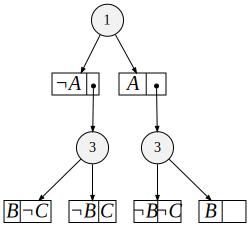

In [7]:
row1 = exactly_one((a,b,c), mgr)
Source(row1.dot())

We apply the function to the remaining rows and columns, then conjoin them.

In [8]:
row2 = exactly_one((d,e,f), mgr)
row3 = exactly_one((g,h,i), mgr)
col1 = exactly_one((a,d,g), mgr)
col2 = exactly_one((b,e,h), mgr)
col3 = exactly_one((c,f,i), mgr)
permutations = row1 & row2 & row3 & col1 & col2 & col3

We then count the number of models in our SDD to get the number of permutations, which is 3! = 6.  We also enumerate all of the models of the SDD, corresponding to each permutation over 3 items.

In [9]:
permutations.model_count()

6

In [10]:
for model in permutations.models():
    print("_______________________________\n")
    print(np.reshape([model[x] for x in sorted(model.keys())],(3,3)))

_______________________________

[[0 1 0]
 [1 0 0]
 [0 0 1]]
_______________________________

[[0 1 0]
 [0 0 1]
 [1 0 0]]
_______________________________

[[0 0 1]
 [1 0 0]
 [0 1 0]]
_______________________________

[[0 0 1]
 [0 1 0]
 [1 0 0]]
_______________________________

[[1 0 0]
 [0 0 1]
 [0 1 0]]
_______________________________

[[1 0 0]
 [0 1 0]
 [0 0 1]]


## Example: Permutations of n items

We can generalize the above example to find the number of permutations of n items, effectively calculating n! by using model counting (albeit, a relatively inefficient approach).

In [11]:
def perm_matrix(n, mgr):
    arr = []
    N = n**2
    for i in range(1,N+1):
        arr.append(mgr.literal(i))
    P = np.reshape(arr, (n,n))
    return P

In [12]:
def factorial(n):
    N = n**2
    vtree = Vtree(N, vtree_type="right")
    mgr = SddManager(vtree = vtree)
    mat = perm_matrix(n, mgr)
    perm = mgr.true()
    for i in range(0,n):
        row = exactly_one(mat[i], mgr)
        col = exactly_one(mat[:,i], mgr)
        perm = perm & row & col
    return perm.model_count()

In [13]:
for n in range(1,11):
    print('{0:2d}! = {1:8d}'.format(n, factorial(n)))

 1! =        1
 2! =        2
 3! =        6
 4! =       24
 5! =      120
 6! =      720
 7! =     5040
 8! =    40320
 9! =   362880
10! =  3628800


## Example: Permanent of a Matrix

The permanent of an n x n square matrix A is defined



\begin{equation*}
perm(A) =  \sum_{\sigma \in \Sigma} \prod_{i=1}^n a_{i,\sigma(i)}
\end{equation*}


We can use weighted model counting to compute the permanent of a matrix. The permanent of a matrix is like the determinant, except that while the determinant alternates between additions and subtractions, the permanent only performs additions.  For example, consider the matrix:
    
    a  b  c
    d  e  f
    g  h  i
    
The determinant is

    a e i - a f h - b d i + b f g + c d h - c e g

The permanent is

    a e i + a f h + b d i + b f g + c d h + c e g

The permanent of an n x n matrix W can be written as a summation over the permutations of n items.

Given an n x n matrix W, we create a matrix of variables for the permutations of n items and set the weight of each literal to the corresponding value in W.

In [14]:
def permanent(A, n):
    N = n**2
    vtree = Vtree(N, vtree_type="right")
    mgr = SddManager(vtree = vtree)
    mat = perm_matrix(n, mgr)
    perm = mgr.true()
    for i in range(0,n):
        row = exactly_one(mat[i], mgr)
        col = exactly_one(mat[:,i], mgr)
        perm = perm & row & col
    wmc = perm.wmc(log_mode=True)
    for i in range(0,n):
        for j in range(0,n):
            wmc.set_literal_weight(mat[i][j], math.log(A[i][j]))
    return math.exp(wmc.propagate())

In [15]:
np.set_printoptions(precision=4, suppress=True, floatmode="fixed")
for i in range(1,6):
    A = np.random.rand(i,i)
    a1 = permanent(A,i)
    print("_______________________________\n")
    print(f" Matrix    : \n  {A}")
    print(f" Permanent : {a1:.4f}")

_______________________________

 Matrix    : 
  [[0.9072]]
 Permanent : 0.9072
_______________________________

 Matrix    : 
  [[0.6862 0.7153]
 [0.0431 0.4703]]
 Permanent : 0.3536
_______________________________

 Matrix    : 
  [[0.5598 0.9392 0.9270]
 [0.6245 0.4243 0.9804]
 [0.4132 0.0515 0.3358]]
 Permanent : 0.8778
_______________________________

 Matrix    : 
  [[0.4118 0.4951 0.8197 0.4143]
 [0.9668 0.7889 0.6162 0.1870]
 [0.2054 0.8213 0.1228 0.2480]
 [0.7527 0.7182 0.1657 0.8859]]
 Permanent : 1.8919
_______________________________

 Matrix    : 
  [[0.2037 0.0684 0.7755 0.9306 0.8899]
 [0.9987 0.3661 0.1277 0.2310 0.7118]
 [0.5239 0.3860 0.3437 0.2624 0.2669]
 [0.0271 0.0474 0.7630 0.3137 0.4128]
 [0.5040 0.5769 0.5978 0.7781 0.4314]]
 Permanent : 2.3038
